<a href="https://colab.research.google.com/github/ramanakshay/Optimal-Transport/blob/main/sinkhorn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Entropic Regularisation of Optimal Transport

##Importing Libraries



In [ ]:
!pip install pot  # Pip Installs Packages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 5.2 MB/s 


In [ ]:
import numpy as np 

import matplotlib.pyplot as plt # plotting

import ot  # ot
import ot.plot
from prettytable import PrettyTable

import time # measure time
from numpy import random

##Helper Functions

In [ ]:
def plot_matrix(M,rlabel = [],clabel = [],cmap = 'viridis',textcolor = 'white',title = "",size = (1.5,1.5)):

  fig = plt.figure()
  ax = fig.add_axes([0.1,0.1,]+list(size)) # main axes

  r,c = M.shape

  if (r <= 10 or c <= 10):
    for i in range(r):
      for j in range(c):
          m = round(M[i][j],3)
          ax.text(i, j, str(m), va='center', ha='center', color = textcolor,fontsize = 66*size[0]/r)


    rlabel = np.round_(rlabel,2)
    clabel = np.round_(clabel,2)

    if (len(rlabel) > 0 and len(clabel) > 0):
      ax.set_xticks(np.arange(0,len(clabel),1))
      ax.set_xticklabels(list(map(str,clabel)))

      ax.set_yticks(np.arange(0,len(rlabel),1))
      ax.set_yticklabels(list(map(str,rlabel)))
     

  ax.xaxis.tick_top()
  ax.xaxis.set_tick_params(labeltop=True)
  ax.xaxis.set_tick_params(labelbottom=False)
  
  ax.set_xlabel(title,fontsize='xx-large')
  M = M.T # MATLAB reads column-wise 
  plt.imshow(M,cmap)
  plt.show()

In [ ]:
def plot_2d_map(xa,xb,P,limit = 0,title =""):
  for i in range(len(xa)):
    for j in range(len(xb)):
      if P[i][j] > limit:
        if (tuple(xa[i]) != tuple(xb[j])):
          plt.arrow(xa[i][0],xa[i][1],xb[j][0]-xa[i][0],xb[j][1]-xa[i][1],width = 0.0001,color = "black", alpha = 0.5*P[i][j]/P.max())
  plt.plot(xa[:, 0], xa[:, 1], '+b', label='Source samples')
  plt.plot(xb[:, 0], xb[:, 1], 'xr', label='Target samples')
  plt.legend(loc=0)

###Cost Matrix Calculator

The cost matrix defines the cost of moving mass from $x_a$ to $x_b$. The $L_n$ metric is used as the distance metric.

$$ \large C_{i,j} = \left [ \left ( \sum^d_{k = 1}\left |  x_i(k)- y_j(k)\right |^n  \right )^ \frac {1}{n} \right ]^{p}$$

where $x_i$ is the position of $a_i$ \
and $y_j$ is the position of $b_j$



In [ ]:
def ln_metric(x,y,n):
  return pow(np.sum(pow(abs(x-y),n),axis = len(x.shape)-1),1/n)

In [ ]:
def euclidean(x,y):
  return pow(np.sum(pow(abs(x-y),2),axis = len(x.shape)-1),1/2)

In [ ]:
def euclidean_sq(x,y):
  return np.sum(pow(abs(x-y),2),axis = len(x.shape)-1)

In [ ]:
def coulomb(x,y,shift):
  x = x.astype(float)
  y = y.astype(float)
  return pow(shift + np.sum(pow(abs(x-y),2),axis = len(x.shape)-1),-1)

In [ ]:
def coulomb_inf(x,y):
  if x.all() == y.all():
    return float('inf')
  else:
    return coulomb(x,y,0)

In [ ]:
def calculate_distance(x,y,dist):
  metrics = {'x':x,'y':y,\
             'euclidean':euclidean,\
             'euclidean_sq':euclidean_sq,\
             'ln_metric':ln_metric,\
             'coulomb': coulomb,\
             'coulomb_inf':coulomb_inf}
  return eval(dist[0]+'(x,y,'+str(dist[1:])[1:],metrics)

In [ ]:
def find_cost_matrix_old(xa,xb,p,dist = ("euclidean",)):
  if isinstance(dist,str):
    dist = (dist,)
  d = xa.shape[1]
  C = []
  for pa in xa:
    row = []
    for pb in xb:
      row.append(pow(calculate_distance(pa,pb,dist),p))
    C.append(row)
  C = np.array(C)
  return C


In [ ]:
def find_cost_matrix(xa,xb,p,dist = ("euclidean",)):
  if isinstance(dist,str):
    dist = (dist,)
  xa_ = np.tile(xa, (1,xa.shape[0])).reshape(xa.shape[0],xb.shape[0],xa.shape[1])
  xb_ = np.tile(xb, (xb.shape[0],1)).reshape(xa.shape[0],xb.shape[0],xb.shape[1])
  return pow(calculate_distance(xa_,xb_,dist),p)

##Sinkhorn Algorithm

In [ ]:
def sinkhorn(a,b,C,epsilon,n):
  u = np.ones(a.shape[0])
  K = np.exp(-C / C.max() / epsilon) #kernel
  
  for i in range(n):
    v = b / np.dot(K.T,u)
    u = a / np.dot(K,v)
    
  P = np.dot(np.diag(u), np.dot(K, np.diag(v)))
  return P

In [ ]:
def auto_sinkhorn(a,b,C,epsilon,error):
  u = np.ones(a.shape[0])
  K = np.exp(-C / C.max() /epsilon) #kernel

  v = b / np.dot(K.T,u)
  u = a / np.dot(K,v)
  P = np.dot(np.diag(u), np.dot(K, np.diag(v)))

  while(np.any(abs(np.sum(P,axis = 1) - a) >= error) or np.any(abs(np.sum(P,axis = 0) - b) >= error)):
    v = b / np.dot(K.T,u)
    u = a / np.dot(K,v)
    P = np.dot(np.diag(u), np.dot(K, np.diag(v)))

  return P

##1D Probability Distributions


###Gaussian (Normal) Distribution

$$ \large f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left (  \frac{x-\mu}{\sigma}\right )^2} $$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution.

In [ ]:
def gaussian_mix(n,mu,std,scale = None):
  assert len(mu) == len(std)
  if scale == None:
    scale = [1]*len(mu)
  x = np.arange(n, dtype = np.float64)
  h = 0
  for i in range(len(mu)):
    h += np.exp(-(x - mu[i]) ** 2 / (2 * std[i] ** 2))*scale[i]
  return h / h.sum()

In [ ]:
# 1D Guassian
n = 200 # number of bins

a = gaussian_mix(n,[20,100],[10,30],[2,1])
b = gaussian_mix(n,[40,150],[20,10],[1.5,1])

x = np.array([[i,] for i in range(n)]) # defining the space

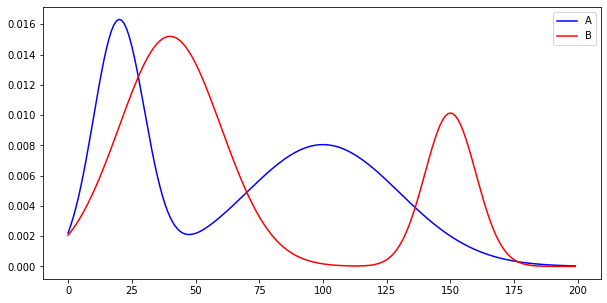

In [ ]:
#Plot distributions
plt.figure(figsize=(10, 5))
plt.plot(x, a, 'b', label='A')
plt.plot(x, b, 'r', label='B')
plt.legend()
plt.show()

###Cost Matrix

<Figure size 504x504 with 0 Axes>

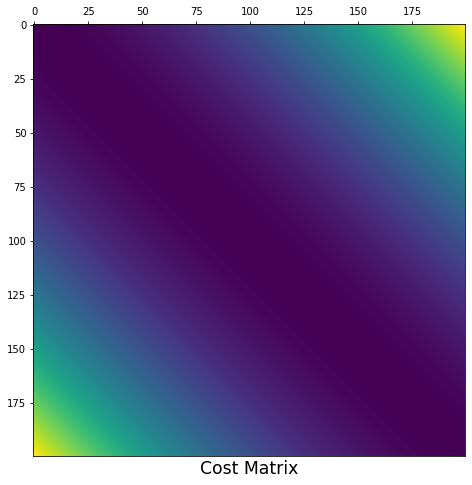

In [ ]:
# Cost Matrix and Defining Distance

p = 2 # set p-value
C = find_cost_matrix_old(x,x,p,dist = ('euclidean'))

plt.figure(3, figsize=(7, 7))
plot_matrix(C,x,x,title = 'Cost Matrix')
plt.show()

###Optimal Coupling


P = argmax optimal coupling / optimal transport plan

Time Taken: 1.465s


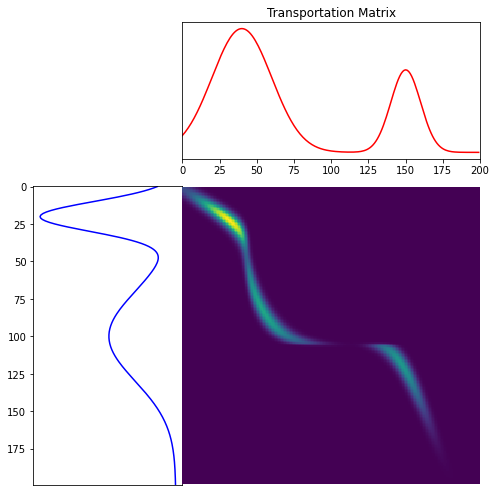

In [ ]:
start = time.time()
P = auto_sinkhorn(a, b, C, 1e-3, 1e-6)
time_emd = time.time() - start

plt.figure(3, figsize=(7, 7))
ot.plot.plot1D_mat(a, b, P, 'Transportation Matrix')

print('Time Taken: ' + str(round(time_emd,3))+ 's')

In [ ]:
float('inf')

inf

Time Taken: 0.008s


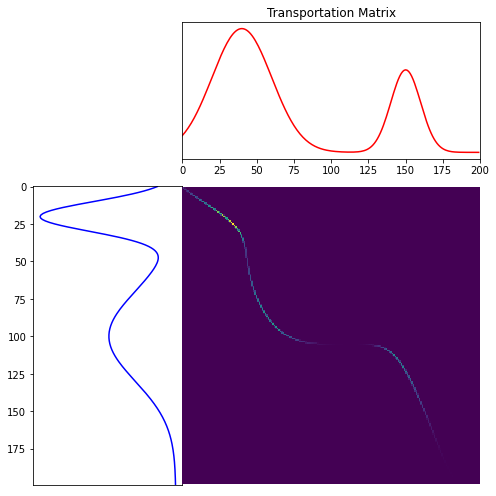

In [ ]:
start = time.time()
P = ot.emd(a,b,C)
time_emd = time.time() - start

plt.figure(3, figsize=(7, 7))
ot.plot.plot1D_mat(a, b, P, 'Transportation Matrix')

print('Time Taken: ' + str(round(time_emd,3))+ 's')

###Comparison

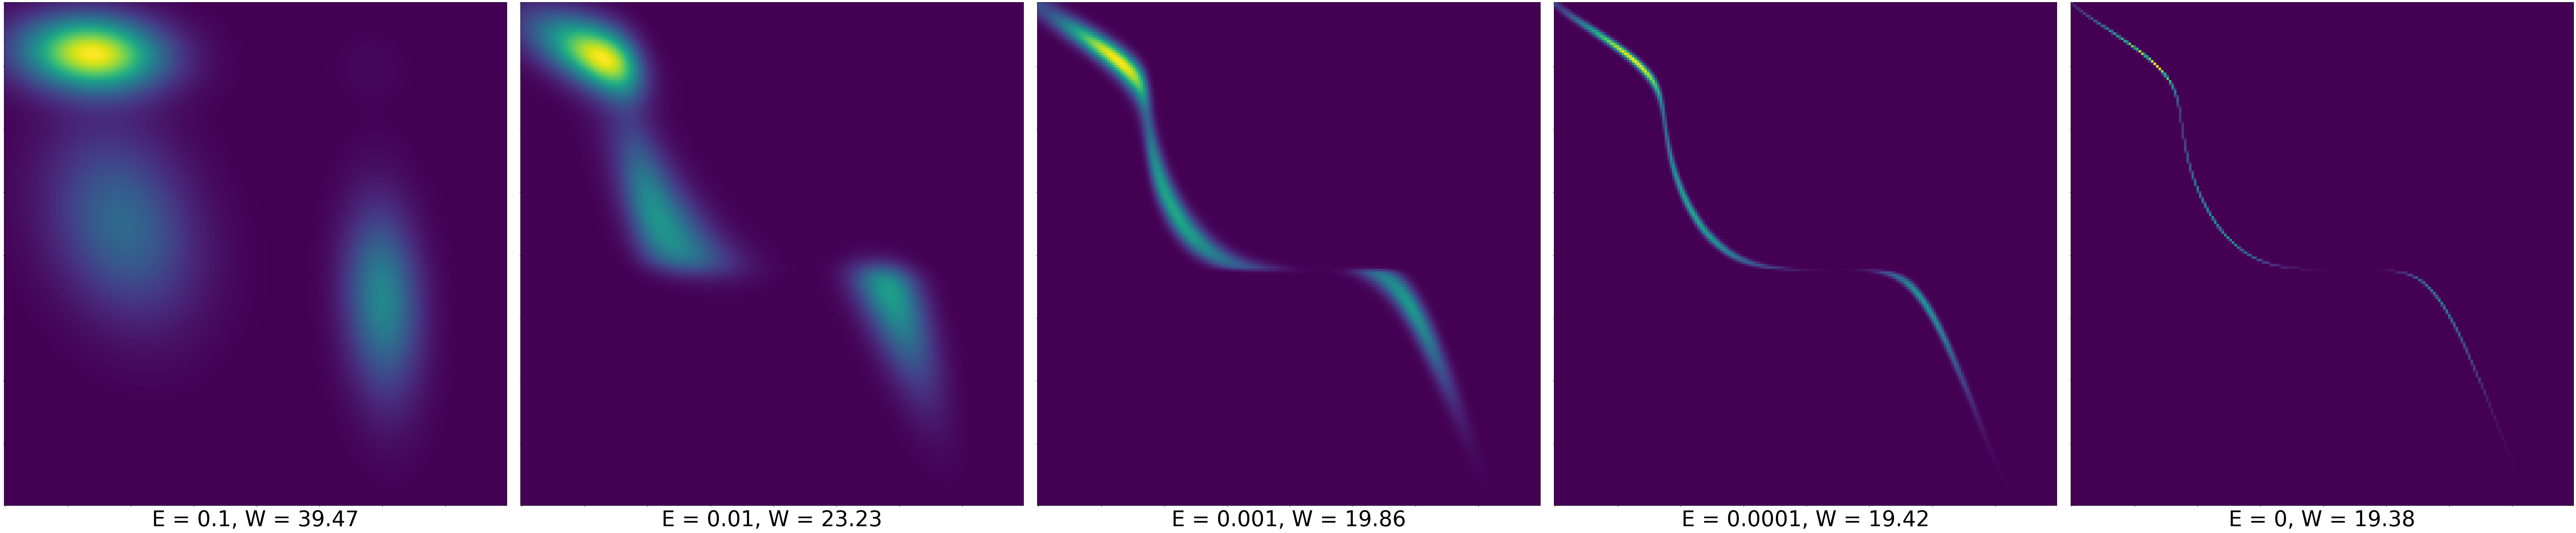

In [ ]:
epsilon = 0.1
fig, axs = plt.subplots(1, 5, constrained_layout=True)
fig.set_figheight(100)
fig.set_figwidth(100)

i = 0
while(epsilon > 0.00001):
  P = auto_sinkhorn(a, b, C,epsilon,1e-6)
  W = pow(np.sum(C*P),1/p)
  axs[i].imshow(P)
  axs[i].set_xlabel('E = ' + str(epsilon) + ", W = " + str(round(W,2)),size = 60)
  axs[i].set_xticklabels([])
  axs[i].set_yticklabels([])
  i += 1
  epsilon /= 10

P = ot.emd(a,b,C)
W = pow(np.sum(C*P),1/p)
axs[i].imshow(P)
axs[i].set_xlabel('E = ' + str(0) + ", W = " + str(round(W,2)),size = 60)
axs[i].set_xticklabels([])
axs[i].set_yticklabels([])
plt.show()

##2D Discrete Points

In [ ]:
n = 10  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([3, 3])
cov_t = np.array([[1, -.8], [-.8, 1]])

xa = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xb = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a = np.ones(n) / n
b = np.ones(n) / n

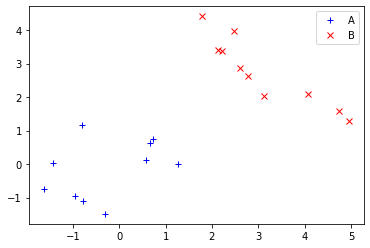

In [ ]:
plt.figure(1)
plt.plot(xa[:, 0], xa[:, 1], '+b', label='A')
plt.plot(xb[:, 0], xb[:, 1], 'xr', label='B')
plt.legend(loc=0)
plt.show()

###Cost Matrix

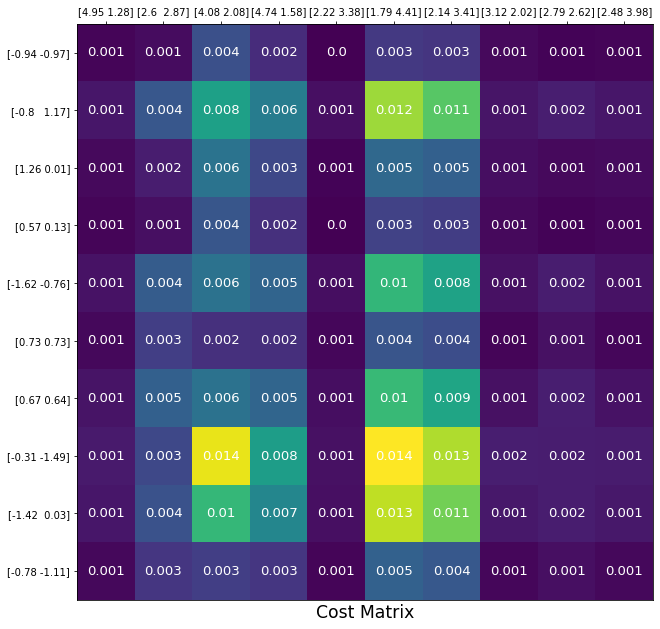

In [ ]:
p = 2
C = find_cost_matrix_old(xa,xb,p,dist = ("coulomb",1))

plot_matrix(C,xa,xb,title = "Cost Matrix",size = (2.0,2.0))

###Sinkhorn

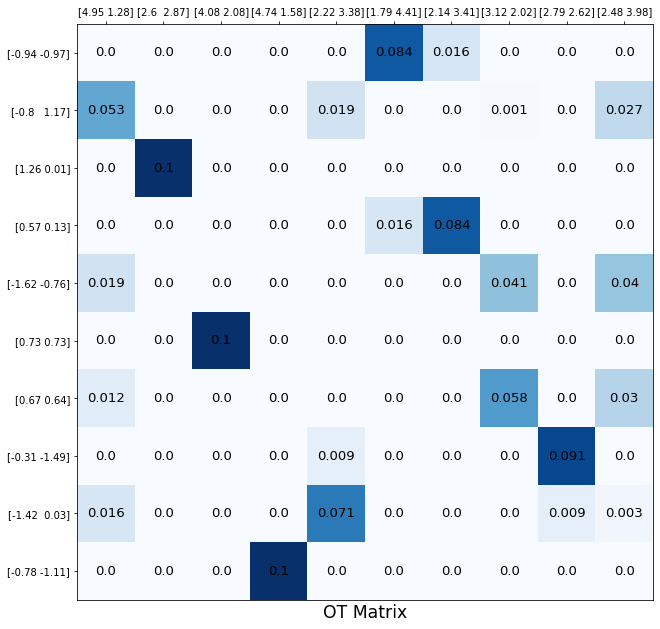

Time Taken: 5.812s


In [ ]:
start = time.time()
P = auto_sinkhorn(a,b,C,1e-3,1e-6)
time_emd = time.time() - start
plot_matrix(P,xa,xb,cmap = plt.cm.Blues,textcolor = 'black',title = 'OT Matrix',size = (2.0,2.0))
print('Time Taken: ' + str(round(time_emd,3))+ 's')

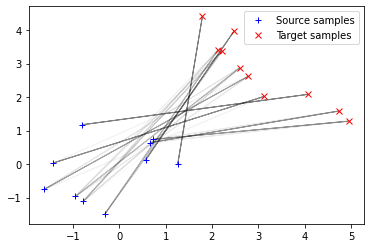

In [ ]:
plt.figure(4)
plot_2d_map(xa,xb,P,limit = 0)
plt.show()

###Wasserstein Distance

In [ ]:
W = pow(np.sum(C*P),1/p)
print('Wasserstein Distance',W)

Wasserstein Distance 0.042556562045113294


###EMD

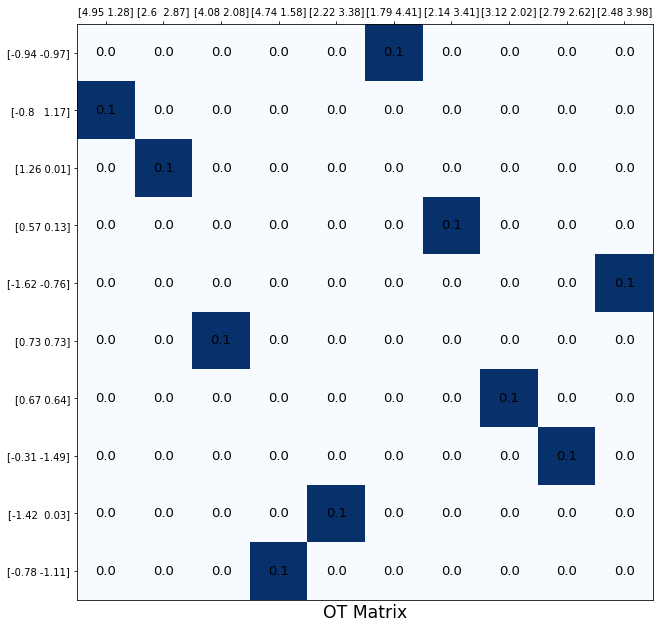

Time Taken: 0.001s


In [ ]:
start = time.time()
P = ot.emd(a,b,C)
time_emd = time.time() - start

plot_matrix(P,xa,xb,cmap = plt.cm.Blues,textcolor = 'black',title = 'OT Matrix',size = (2.0,2.0))
print('Time Taken: ' + str(round(time_emd,3))+ 's')

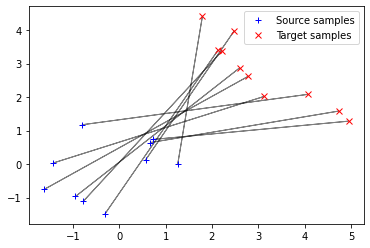

In [ ]:
plt.figure(4)

plot_2d_map(xa,xb,P,limit = 0)
plt.show()

###Comparison

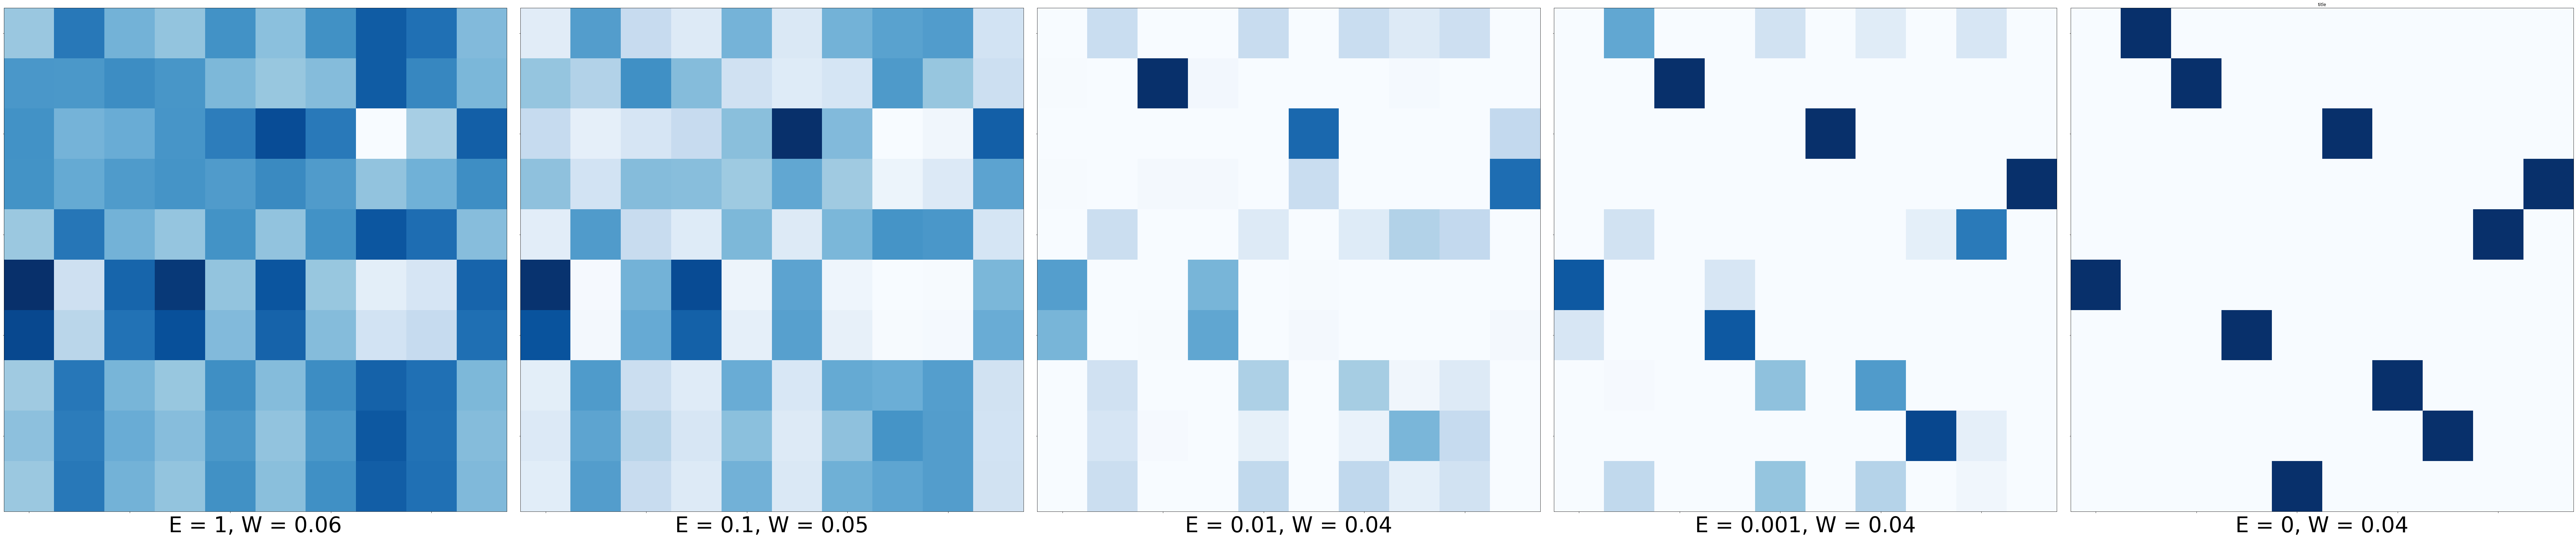

In [ ]:
epsilon = 1
fig, axs = plt.subplots(1, 5,constrained_layout=True)
fig.set_figheight(100)
fig.set_figwidth(100)

plt.gca().set_title('title')
i = 0
while(epsilon >= 0.001):
  P = auto_sinkhorn(a, b, C,epsilon,1e-6)
  W = pow(np.sum(C*P),1/p)
  axs[i].imshow(P,cmap = plt.cm.Blues)
  axs[i].set_xlabel('E = ' + str(epsilon) + ", W = " + str(round(W,2)),size = 60)
  axs[i].set_xticklabels([])
  axs[i].set_yticklabels([])
  i += 1
  epsilon /= 10

P = ot.emd(a,b,C)
W = pow(np.sum(C*P),1/p)
axs[i].imshow(P,cmap = plt.cm.Blues)
axs[i].set_xlabel('E = ' + str(0) + ", W = " + str(round(W,2)),size = 60)
axs[i].set_xticklabels([])
axs[i].set_yticklabels([])
plt.show()

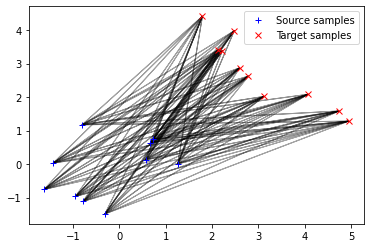

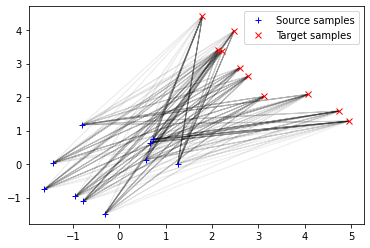

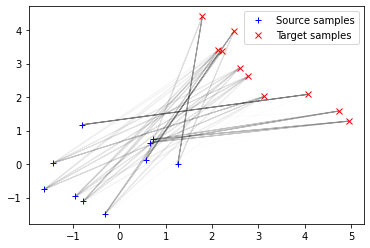

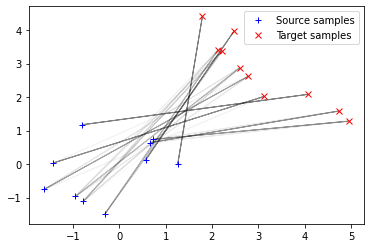

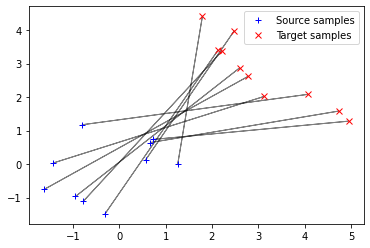

In [ ]:
epsilon = 1
k = 1
while(epsilon >= 0.001):
  P = auto_sinkhorn(a, b, C,epsilon,1e-6)
  W = pow(np.sum(C*P),1/p)
  plt.figure(k)
  plot_2d_map(xa,xb,P,limit = 1e-5)
  plt.show()
  k += 1
  epsilon /= 10

P = ot.emd(a,b,C)
W = pow(np.sum(C*P),1/p)
plot_2d_map(xa,xb,P,limit = 0)